In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount ('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Mounted at /content/drive


In [5]:
# Cek Missing Values Kolom
print("Jumlah Missing Values :")
print(df.isnull().sum())

Jumlah Missing Values :
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


In [6]:
# Drop Missing Values
df = df.dropna(subset=['rx_kbps','tot_kbps'])
print(df.isnull().sum())

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64


In [7]:
# Melakukan penanganan fitur kategorikal dengan mengubah menjadi binary menggunakan OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

df['Protocol'] = df ['Protocol'].astype(str)
encoder = OneHotEncoder(sparse_output=False)
encoder_clean = encoder.fit_transform(df[['Protocol']]).astype(int)
encoder_clean = pd.DataFrame(
    encoder_clean,
    columns= encoder.get_feature_names_out(['Protocol']),
    index= df.index
)
df = pd.concat([df.drop(columns=['Protocol']), encoder_clean], axis=1)

In [10]:
#Melihat kolom yang telah di OneHotEncoder
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes',
       'tx_kbps', 'rx_kbps', 'tot_kbps', 'label', 'Protocol_ICMP',
       'Protocol_TCP', 'Protocol_UDP'],
      dtype='object')

In [11]:
# Memilih fitur yang relevan dalam mendeteksi DDoS
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol_ICMP','Protocol_TCP','Protocol_UDP','port_no',
    'tx_kbps','rx_kbps','tot_kbps'
]
df_clean = df[Features]

In [13]:
# Membagi data dengan komposisi X = 80% dan y = 20% untuk model
from sklearn.model_selection import train_test_split

X = df_clean
y = df['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
# Menghitung rasio untuk imbalance
ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
print("Ratio class imbalance (0/1)",ratio)

#Hasilnya akan menunjukkan Kelas 0(Normal) ada 1,56x lebih banyak daripada kelas 1(DDoS) di training set

Ratio class imbalance (0/1) 1.5636823750887263


In [42]:
#Model LightGBM
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='binary',
    metric ='auc',
    boosting_type ='gbdt',
    num_leaves = 31,
    learning_rate = 0.05,
    n_estimators= 1000,
    #scale_pos_weight=ratio, #Uncomment jika ingin menangani imbalance
    random_state=42
)

In [43]:
#Training Model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(100)]
)

[LightGBM] [Info] Number of positive: 32403, number of negative: 50668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 83071, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390064 -> initscore=-0.447044
[LightGBM] [Info] Start training from score -0.447044
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's auc: 1


LGBMClassifier(learning_rate=0.05, metric='auc', n_estimators=1000,
               objective='binary', random_state=42)

In [53]:
#Prediksi Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score

y_predik = model.predict(X_test)
akurasi = accuracy_score(y_test, y_predik)
print(f"Akurasi : {akurasi:.4f}")

Akurasi : 0.9995


In [54]:
print(classification_report(y_test, y_predik))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12667
           1       1.00      1.00      1.00      8101

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768



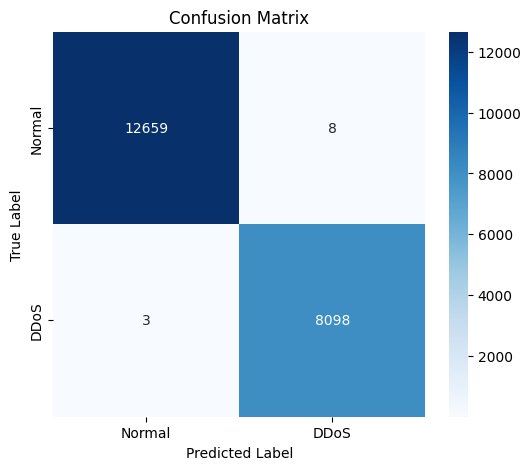

In [55]:
#Membuat grafik evaluasi confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_predik)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = label,
            yticklabels = label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

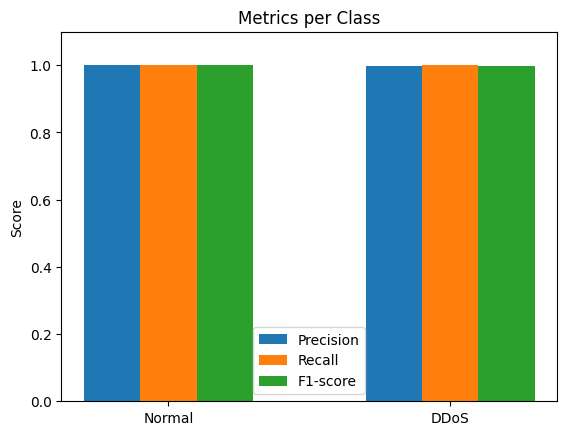

In [56]:
import numpy as np

precision = precision_score(y_test, y_predik, average=None)
recall = recall_score(y_test, y_predik, average=None)
f1 = f1_score(y_test, y_predik, average=None)
classes = ['Normal','DDoS']

X = np.arange(len(classes))
width = 0.2

plt.bar(X - width, precision, width, label='Precision')
plt.bar(X, recall, width, label ='Recall')
plt.bar(X + width, f1, width, label='F1-score')
plt.xticks(X, classes)
plt.ylabel('Score')
plt.ylim(0,1.1)
plt.title('Metrics per Class')
plt.legend()
plt.show

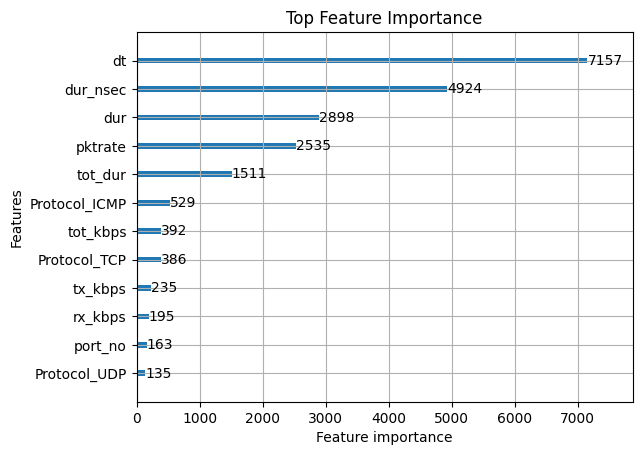

In [57]:
import lightgbm as lgb

lgb.plot_importance(model)
plt.title("Top Feature Importance")
plt.show()

In [58]:
import joblib
joblib.dump(model, 'lightbgm_detectionDDoS.pkl')

['lightbgm_detectionDDoS.pkl']

In [59]:
from google.colab import files
files.download('lightbgm_detectionDDoS.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>